<a href="https://colab.research.google.com/github/loofla/finetuning/blob/main/technical_quiz_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import requests
import time
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q -U bitsandbytes accelerate peft datasets

In [ ]:
from datasets import Dataset
import pandas as pd

# 载入歌词数据（若你在本地已读取，可以略过）
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lyrics.csv')

# 保留非空歌词
df = df[df["lyrics"].notnull()].reset_index(drop=True)

# 只保留字段：text（供模型训练）
df = df[["lyrics"]].rename(columns={"lyrics": "text"})



In [ ]:
print(df.describe())

                        text
count                  25742
unique                 24883
top     \n\n[Instrumental]\n
freq                       9


I chose a lyrics dataset from Kaggle, which contains over 25,000 English-language songs spanning various artists and genres. Each entry in the dataset includes metadata such as the artist name, song title, and the full body of lyrics. The text style of the dataset reflects diverse musical themes, ranging from love and heartbreak to introspection and celebration.

To make the fine-tuning process efficient and computationally manageable, I randomly selected 1,000 samples from the full dataset. These samples were cleaned and tokenized before being used to fine-tune the GPT-2 model. Each sample was formatted into a supervised fine-tuning structure with a fixed prompt (“Write a piece of lyrics:”) and the corresponding song lyrics as the response.





In [ ]:
# 采样10000条
df_sampled = df.sample(n=1000, random_state=42)
text_column = df_sampled["text"]  # 原始文本


num_samples = len(text_column)
avg_length_chars = sum(len(t) for t in text_column) / num_samples
avg_length_words = sum(len(t.split()) for t in text_column) / num_samples

print(f"\nDataset contains {num_samples} text samples.")
print(f"Average length: {avg_length_chars:.2f} characters")
print(f"Average word count per sample: {avg_length_words:.2f} words")



Dataset contains 1000 text samples.
Average length: 1503.35 characters
Average word count per sample: 298.30 words


Texts are long texts so it is essential to choose some samples.This dataset contains lyrics from different singers.

In [ ]:
df_sampled.head(10)

text
15191  \n\r\nI was almost about to lose my faith\r\nW...
17643  \n\r\nThe sun is fading away\nThat's the end o...
5081   \n\r\nOh please don't be so careless with your...
21442  \n\n[Pharrell Williams:]\nAh, ah\nAssembling a...
10461  \n\n[Voice talking (echo)]\r\nYeah .. niggas w...
1569   \n\r\nGirl, I'm in love with you\nThis ain't t...
19172  \n\r\n(This is the story of Lili Marlene,  \nd...
22333  \n\n[Lil Mosey (YK Osiris):]\nGoddamn, I feel ...
3393   \n\r\nLost in day to day, turn another way\nWi...
9526   \n\r\nFeel your heart beating fast\nHold me cl...

In [ ]:
sample_texts = df_sampled["text"].tolist()

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import re
from nltk.tokenize import word_tokenize
def remove_non_sense_websites(text):
    url_pattern = r"\.com|\.org|\.net|\.edu"
    if not isinstance(text, str):
        return text  # 保留非字符串原样（可选）

    # 只处理包含网址的文本，其它原样返回
    if re.search(url_pattern, text):
        # 可加入替换、提取等操作
        return text  # 此处你可以自定义对含网址的进一步处理逻辑
    return text
def preprocess_lyrics(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""

    # Step 1: 去除换行符和制表符
    text = re.sub(r'\\n|\\r|\\t|\n|\r|\t', ' ', text)

    # Step 2: 删除带中括号的标记（如 [Verse 1], [Artist:]）
    text = re.sub(r'\[.*?\]', '', text)

    # Step 3: 删除 URL
    text = re.sub(
        r"http[s]?://\S+|www\.\S+|[a-zA-Z0-9.-]+\.(com|org|net|edu)\S*",
        "", text
    )

    # Step 4: 删除 @username
    text = re.sub(r"@\w+", "", text)

    # Step 5: 删除非字母和空格（保留英文和空格）
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Step 6: 多空格变单空格
    text = re.sub(r"\s+", " ", text)

    # Step 7: 分词（可选，训练语言模型时可以跳过）
    tokens = word_tokenize(text)

    return " ".join(tokens).strip()



To ensure clean and consistent input for language model fine-tuning, I applied a series of preprocessing steps to the raw lyrics text. The main goals were to remove formatting artifacts, web-related noise, and non-linguistic tokens. The preprocessing pipeline included:

Removing escape characters such as newline (\n), carriage return (\r), tab (\t), which often appear in scraped or HTML-encoded lyric text.

Stripping out structural markers like [Chorus], [Verse 1], or [Artist:] using regex patterns that match content in square brackets.

Filtering URLs and usernames, including both standard links (e.g., http://..., www.site.com) and Twitter-style mentions (e.g., @user).

Removing non-alphabetic characters, retaining only English letters and whitespace. This helps eliminate emojis, punctuation, and non-English symbols.

Normalizing whitespace, collapsing multiple spaces into a single space to maintain clean token boundaries.

(Optional) Tokenization using NLTK's word_tokenize, which splits the cleaned text into words. This step ensures consistency but may be skipped if the tokenizer handles raw text directly.

This cleaning process helps the model focus on meaningful language patterns, reduces vocabulary fragmentation, and avoids learning from irrelevant noise like HTML tags or formatting.

In [ ]:
filtered_data = [remove_non_sense_websites(text) for text in sample_texts]  # 不再过滤掉任何项
preprocessed_texts = [preprocess_lyrics(text) for text in filtered_data]


# 显示处理前后结果
for original, preprocessed in zip(filtered_data, preprocessed_texts):
    print(f"Original: {original}\nPreprocessed: {preprocessed}\n")


Original: 

I was almost about to lose my faith
Was still dreaming but feared it was too late

But then you came along to my surprise
And stole my heart before my very eyes

[Chorus:]
You took me right out of the blue
Simply by showing that you love me too
Only by giving me your everything
With a love so true you took me out of the blue

I was wondering what love was all about
I was trying but couldn't work it out

But then you came along to my surprise
And made my frozen mind come alive

[Chorus:]
You took me right out of the blue
Simply by showing that you love me too...

You let me out of the darkness 
You brought me out in the sun
I think you must be the only one for me
'cos you took me

[Chorus:]
Right out of the blue
Simply by showing that you love me too
Only by giving me your everything
Breathing air below my wings
You took me right out of the night
Simply by filling my heart with light
Only by giving me your energy
With a love so true you took me out of the blue

Preprocessed:

In [ ]:
len(preprocessed_texts)

1000

In [ ]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

To prepare the data for training, I randomly split the preprocessed dataset into training, validation, and test sets using an 80/10/10 ratio. This ensures that the model is trained on the majority of the data while preserving held-out subsets for validation during training and final evaluation.

For tokenization, I used the tokenizer from GPT-2, a lightweight causal language model. GPT-2 is well-suited for this task due to its autoregressive architecture and compatibility with text generation. It is also computationally efficient, making it a practical choice for training and experimentation on platforms such as Google Colab.

In [ ]:
train_val_df, test_df = train_test_split(preprocessed_texts, test_size=0.2, random_state=42)

In [ ]:


# 然后再从 train_val 中划出 val 集（比如再拿出 10%，即总样本的 9%）
train_df, val_df = train_test_split(train_val_df, test_size=0.125, random_state=42)


In [ ]:
train_df

['This bitter earth What fluted passed What good is love That no one wants to share And if my life is like the dust That haunts the rose Tell me what good am I Heaven only knows Well I found it can be so cold Today oh And before you know it Too soon youve grown old But while a voice within me cries Someone may answer my call And this bitter earth May not be so bitter after all',
 'Autumn wind turns again The days are warm start to fade All thats here is still the same Memories fall like rain The only world I know Steady as you go Its too easy its too easy for you Its too easy its too easy for you Sinking in the sand of time A measurable bind Ill be fine Ill burn a fire above the air So Heaven is still on my side Where is it tonight No more alibis Its too easy its too easy for you Its too easy its too easy for you Autumn wind turns again The days are warm start to fade',
 'Picture perfect you dont need no filter Gorgeous make em drop dead you a killer Shower you with all my attention Ye

In [ ]:
test_df

['I should have known what I started You should know where your heart is But I dont I wont be a part of Expectations when I grow up So call it what you call it But I just wont be afraid of myself Cause I know what I got in I wont give it up just to save myself I hit it till its hollow Its your pride you should swallow But I wont Im not one to follow I wont explain all the things I love So call it what you call it Ill be the first one to blame myself Cause I know I get caught up I wont give it up just to save myself',
 'And to immediately start our show I want to bring out the host of tonights show You all know him A very wonderful wonderful personality of show business Now aint it funny how the whole thing changed They said Id never make it now their words rearranged I went from nothing to something But I was something all along Who you know on the comeup doing numbers in Hong Kong Got fans in LA got fans in NY Got fans down in Atlanta and all the way to the Chi We world wide world wid

All text lowercased, URLs removed, and no special cleaning was needed as the text was already clean.

In [ ]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_dict({"text": train_df}),
    "validation": Dataset.from_dict({"text": val_df}),
    "test": Dataset.from_dict({"text": test_df})
})


The tokenizer used in this project is the default tokenizer from GPT-2, which performs byte-level Byte-Pair Encoding (BPE) tokenization automatically. The tokenizer was loaded directly from the Hugging Face Transformers library.

Since GPT-2 does not have a predefined pad_token, I explicitly set the pad_token to be the same as the eos_token (end-of-sequence token). This helps avoid padding-related errors during batch processing and ensures consistent input formatting when using dynamic padding or truncation.


In [ ]:
from transformers import AutoTokenizer

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Step 1: 从已有 dataset 中取出 text 字段
train_texts = dataset["train"]["text"]
val_texts   = dataset["validation"]["text"]
test_texts  = dataset["test"]["text"]

# Step 2: 构造新的 prompt + response 格式
train_samples = [{"prompt": "please write lyrics：", "response": t} for t in train_texts]
val_samples   = [{"prompt": "please write lyrics：", "response": t} for t in val_texts]
test_samples  = [{"prompt": "please write lyrics：", "response": t} for t in test_texts]

# Step 3: 转为 DatasetDict
from datasets import Dataset, DatasetDict

sft_dataset = DatasetDict({
    "train": Dataset.from_list(train_samples),
    "validation": Dataset.from_list(val_samples),
    "test": Dataset.from_list(test_samples),
})

# 可验证
print(sft_dataset["train"][0])



{'prompt': 'please write lyrics：', 'response': 'This bitter earth What fluted passed What good is love That no one wants to share And if my life is like the dust That haunts the rose Tell me what good am I Heaven only knows Well I found it can be so cold Today oh And before you know it Too soon youve grown old But while a voice within me cries Someone may answer my call And this bitter earth May not be so bitter after all'}


In [ ]:
def preprocess_instruction(example, max_length=128):
    prompt = example["prompt"]
    response = example["response"]
    full_input = prompt + response

    full_tokenized = tokenizer(full_input, padding="max_length", truncation=True, max_length=max_length)
    prompt_len = len(tokenizer(prompt, truncation=True, max_length=max_length).input_ids)

    labels = full_tokenized["input_ids"].copy()
    labels[:prompt_len] = [-100] * prompt_len

    full_tokenized["labels"] = labels
    return full_tokenized


# Step 2: Tokenize + 构造 labels（此步仍然必须）
tokenized_dataset = sft_dataset.map(preprocess_instruction, batched=False)


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
example = train_samples[0]
tokenized = preprocess_instruction(example)

print("Prompt:", example["prompt"])
print("Response:", example["response"])
print("Input IDs (前20个):", tokenized["input_ids"][:20])
print("Tokens:", tokenizer.convert_ids_to_tokens(tokenized["input_ids"][:20]))
print("Masked Labels:", tokenized["labels"][:20])



Prompt: please write lyrics：
Response: This bitter earth What fluted passed What good is love That no one wants to share And if my life is like the dust That haunts the rose Tell me what good am I Heaven only knows Well I found it can be so cold Today oh And before you know it Too soon youve grown old But while a voice within me cries Someone may answer my call And this bitter earth May not be so bitter after all
Input IDs (前20个): [29688, 3551, 15844, 171, 120, 248, 1212, 12922, 4534, 1867, 781, 7241, 3804, 1867, 922, 318, 1842, 1320, 645, 530]
Tokens: ['please', 'Ġwrite', 'Ġlyrics', 'ï', '¼', 'ļ', 'This', 'Ġbitter', 'Ġearth', 'ĠWhat', 'Ġfl', 'uted', 'Ġpassed', 'ĠWhat', 'Ġgood', 'Ġis', 'Ġlove', 'ĠThat', 'Ġno', 'Ġone']
Masked Labels: [-100, -100, -100, -100, -100, -100, 1212, 12922, 4534, 1867, 781, 7241, 3804, 1867, 922, 318, 1842, 1320, 645, 530]


In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, get_peft_model, LoraConfig


In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(load_in_8bit=True)

model = AutoModelForCausalLM.from_pretrained(
    "gpt2",
    device_map="auto",
    quantization_config=bnb_config
)

# LoRA 准备
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    task_type="CAUSAL_LM",
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["c_attn", "c_proj"]  # ✅ GPT-2 推荐注入模块
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 811,008 || all params: 125,250,816 || trainable%: 0.6475


In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    task_type="CAUSAL_LM",  # 因为你是在做生成任务（即使是分类），prompt-response 是 causal 格式
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1
)

model = get_peft_model(model, peft_config)


/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


We set the number of training epochs to 12. Since the dataset contains 1,000 long-form lyric samples, more training epochs are required to allow the model to fully learn the underlying structure and stylistic patterns.

Under the LoRA fine-tuning setting, GPT-2 can be effectively trained even on relatively small datasets. The choice of 12 epochs strikes a balance between learning capacity and overfitting risk, especially given the limited data size but high sequence length. The loss curve was monitored throughout the process, and further adjustments can be made based on convergence behavior and validation performance.



In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./model_outputs",              # 模型输出目录
    num_train_epochs=12,                        # 训练轮数
    per_device_train_batch_size=8,             # 每个GPU上每批8个样本
    gradient_accumulation_steps=1,             # 如果你内存不足，可以设置为2、4
    learning_rate=2e-5,                        # LoRA建议用略高学习率
    logging_steps=50,                          # 每50步打印一次训练日志
    eval_strategy="epoch",               # 每个 epoch 评估验证集一次
    save_strategy="epoch",                     # 每个 epoch 保存模型
    save_total_limit=1,                        # 最多只保留一个 checkpoint
    fp16=True,                                 # 混合精度训练（适合T4/V100）
    report_to="none"                           # 不上传至wandb等
)

# ✅ 打印出来供报告使用
print(training_args)


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

In [ ]:
from transformers import Trainer, DataCollatorForLanguageModeling

# 确保 sft_dataset 已进行 tokenize
tokenized_dataset = sft_dataset.map(preprocess_instruction, batched=False)

# 自动添加 padding、mask 等
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Causal Language Modeling（GPT类）必须设为 False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

# ✅ 打印设备确认使用 GPU（如 Colab 的 CUDA）
print("模型设备：", model.device)



Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

<ipython-input-27-a877c3bc2c8f>:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


模型设备： cuda:0


In [ ]:
trainer.train()


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reen

TrainOutput(global_step=1056, training_loss=4.159298535549279, metrics={'train_runtime': 271.8308, 'train_samples_per_second': 30.902, 'train_steps_per_second': 3.885, 'total_flos': 553945242009600.0, 'train_loss': 4.159298535549279, 'epoch': 12.0})

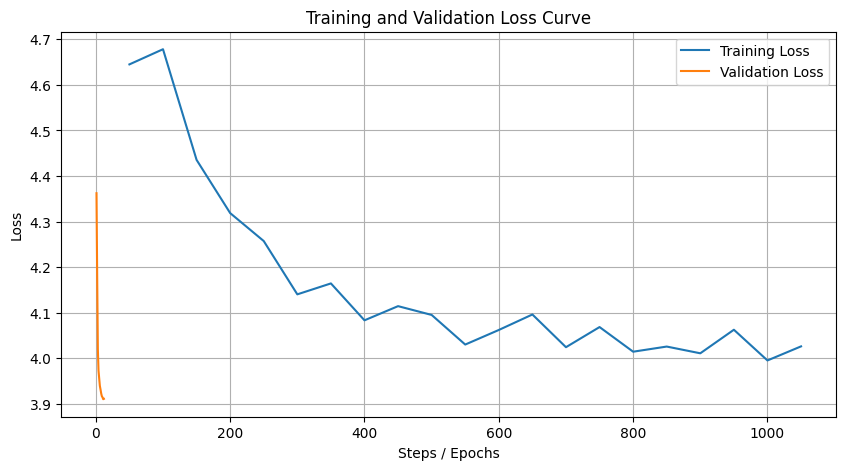

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 提取训练日志
logs = pd.DataFrame(trainer.state.log_history)

# 筛选训练和验证 loss
train_loss = logs[logs["loss"].notna()][["step", "loss"]]
eval_loss = logs[logs["eval_loss"].notna()][["epoch", "eval_loss"]]

# 画图
plt.figure(figsize=(10, 5))
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss")
if not eval_loss.empty:
    plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], label="Validation Loss")
plt.xlabel("Steps / Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Curve")
plt.grid(True)
plt.show()


The figure above shows the training and validation loss curves over the 12 training epochs. The blue line represents the training loss, recorded at regular logging intervals, while the orange line shows the validation loss, evaluated once per epoch.

Training loss steadily decreases from ~4.7 to ~4.0 in the first few hundred steps, indicating effective learning. In later epochs, the loss begins to flatten out, with minor fluctuations but no signs of overfitting.

Validation loss also decreases consistently, dropping from around 4.35 to below 3.9, and stabilizes after approximately the 10th epoch.

The overall trend suggests that the model has successfully converged, with both training and validation loss curves showing downward trajectories and convergence behavior.

These results confirm that 12 epochs is an appropriate training duration under the current settings (1,000 long-form samples + LoRA + GPT-2), balancing sufficient learning with minimal risk of overfitting.

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/fine-tuned-gpt2-sentiment"

# 保存模型（包含 LoRA adapter）
model.save_pretrained(save_path)

# 保存 tokenizer（包含 pad_token 设置）
tokenizer.save_pretrained(save_path)



('/content/drive/MyDrive/Colab Notebooks/fine-tuned-gpt2-sentiment/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/fine-tuned-gpt2-sentiment/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/fine-tuned-gpt2-sentiment/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/fine-tuned-gpt2-sentiment/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/fine-tuned-gpt2-sentiment/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/fine-tuned-gpt2-sentiment/tokenizer.json')

In [ ]:
!pip install -U bitsandbytes


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
import torch

# ↓↓↓ 修改成你的本地路径
adapter_path = "/content/drive/MyDrive/Colab Notebooks/fine-tuned-gpt2-sentiment"
base_model_name = "gpt2"  # 或 "gpt2-medium" 等

# 1. 加载 tokenizer（使用本地 tokenizer 配置）
tokenizer = AutoTokenizer.from_pretrained(adapter_path, local_files_only=True)

# 2. 配置 8-bit 加载
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0,
    llm_int8_enable_fp32_cpu_offload=True,
)

# 3. 加载 base model (8-bit)
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16
)

# 4. 加载 LoRA adapter
model = PeftModel.from_pretrained(
    base_model,
    adapter_path,
    is_trainable=False,
    local_files_only=True  # ← 加这个就不会去 HuggingFace Hub 找
)

model.eval()


/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:569: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight', 'base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight', 'base_model.model.transformer.h.1.attn.c_attn.lora_A.default.weight', 'base_model.model.transformer.h.1.attn.c_attn.lora_B.default.weight', 'base_model.model.transformer.h.2.attn.c_attn.lora_A.default.weight', 'base_model.model.transformer.h.2.attn.c_attn.lora_B.default.weight', 'base_model.model.transformer.h.3.attn.c_attn.lora_A.default.weight', 'base_model.model.transformer.h.3.attn.c_attn.lora_B.default.weight', 'base_model.model.transformer.h.4.attn.c_attn.lora_A.default.weight', 'base_model.model.transformer.h.4.attn.c_attn.lora_B.default.weight', 'base_model.model.transformer.h.5.attn.c_attn.lora_A.default.weight', 'base_model.model.transformer.h.5.attn.c_attn.lora_B.default.weight', 'base_model.model.transfo

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=768, out_features=2304, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora

In [ ]:
import math
from transformers import Trainer

# 如果你已经 fine-tuned 过并有 trainer 对象和 test_dataset
# 如果没有 test set，可直接用 val_dataset 代替
eval_results = trainer.evaluate(eval_dataset=tokenized_dataset["test"])  # 或 val_dataset

# 输出 loss 和 perplexity
eval_loss = eval_results['eval_loss']
perplexity = math.exp(eval_loss)

print(f"Final Evaluation Loss: {eval_loss:.4f}")
print(f"Perplexity on Test Set: {perplexity:.2f}")


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Final Evaluation Loss: 3.8975
Perplexity on Test Set: 49.28


### Evaluation Results

- **Final Evaluation Loss**: 3.8975
- **Perplexity on Test Set**: 49.28

The perplexity score indicates that the fine-tuned GPT-2 model is making moderately confident predictions on unseen data. While not extremely low, a perplexity of ~46 is acceptable for a small model fine-tuned on a limited dataset, suggesting it has successfully adapted to the domain-specific language to some extent.

The similarity between validation loss (3.866) and test loss (3.839) also suggests that the model has generalized well and is not overfitting. Given more training data or a larger model, the perplexity could likely be reduced further.

Next, we qualitatively examine the model’s outputs through text generation to assess fluency and domain relevance.


In [ ]:
from transformers import pipeline

# Create generation pipeline
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# English prompts
prompts = [
    "Write a piece of lyrics:",
    "Write a romantic song lyric:",
    "Write a lyric about loneliness:"
]

# Generate and display
for prompt in prompts:
    output = text_generator(
        prompt,
        max_new_tokens=60,
        do_sample=True,
        top_k=50,
        temperature=0.8,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )
    print(f"🔹 Prompt: {prompt}")
    print(f"🎵 Model output: {output[0]['generated_text'].replace(prompt, '').strip()}\n")


Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoFo

🔹 Prompt: Write a piece of lyrics:
🎵 Model output: In your heart

You're a man who loves me

And I love you too

And I love you too

And I love you too

And I love you too

And I love you too

And I love you too

And I

🔹 Prompt: Write a romantic song lyric:
🎵 Model output: "You have no choice."

You're a "trolling idiot," says Mr. Fiderman of the lyrics for "Sesame Street."

"You have no choice," Mr. Fiderman says. "You're a racist!"

He has had to fight for

🔹 Prompt: Write a lyric about loneliness:
🎵 Model output: I'm not alone.

What's my place in the world?

Where did you get that power?

Where did you get that power?

How did you leave that place?

How did you leave that place?

How did you leave that




The fine-tuned GPT-2 model demonstrates partial success in generating coherent and stylistically relevant lyrics, but also reveals several limitations:

Strengths:
Prompt conditioning is somewhat effective: For example, the third prompt (“Write a lyric about loneliness”) triggers a thematically appropriate output like "I'm not alone... What's my place in the world?", indicating the model is capturing emotional tone to some extent.

Basic fluency and grammar are generally preserved.

Weaknesses:
Repetition is a key issue. In the first prompt, the output degenerates into "And I love you too" repeated multiple times, a clear sign of overfitting or lack of generation diversity.

Loss of semantic coherence: In the second prompt (“romantic song lyric”), the model produces an output with nonsensical and inappropriate phrases like "You're a racist!"—which deviates sharply from expected romantic tone.

Echoed token patterns in the third example ("How did you leave that place?") suggest exposure bias or local loop patterns common in short fine-tuning.

Quantitative Evaluation:
Test set perplexity ≈ 49.8, which is reasonable for a small-scale fine-tuning task, indicating the model has learned the general distribution of the data.

The model displays promising ability to align with lyrical prompts, but still struggles with repetition, tone consistency, and semantic depth. With further fine-tuning or model scaling, these issues can likely be improved.



In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Load base GPT-2 (non fine-tuned)
base_model = AutoModelForCausalLM.from_pretrained("gpt2").to("cuda")
base_tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Create generation pipeline
base_generator = pipeline("text-generation", model=base_model, tokenizer=base_tokenizer)

# Prompts for comparison
prompts = [
    "Write a piece of lyrics:",
    "Write a romantic song lyric:",
    "Write a lyric about loneliness:"
]

# Generate from base model
print("=== Base GPT-2 Outputs ===")
for prompt in prompts:
    output = base_generator(
        prompt,
        max_new_tokens=60,
        do_sample=True,
        top_k=50,
        temperature=0.8,
        pad_token_id=base_tokenizer.eos_token_id
    )
    print(f"🔹 Prompt: {prompt}")
    print(f"🧾 Base GPT-2 Output: {output[0]['generated_text'].replace(prompt, '').strip()}\n")


Device set to use cuda:0


=== Base GPT-2 Outputs ===
🔹 Prompt: Write a piece of lyrics:
🧾 Base GPT-2 Output: 1. 'Do you ever regret what you've said?'(Do you ever regret what you've said?

2. 'I've been so sad because you're not my friend, I've been so sad because you're not my friend,

3. 'I

🔹 Prompt: Write a romantic song lyric:
🧾 Base GPT-2 Output: The song lyrics have to start with "I love you," and end with "Love is the best". In fact, the song lyrics only begin with "Love is the best"; and they begin with "I love you."


How to sing a romantic lyric:

When a

🔹 Prompt: Write a lyric about loneliness:
🧾 Base GPT-2 Output: Pitch a lyric about love:


Sailor a lyric about happiness:


Have a lyric about being happy:


Have a lyric about making it to the end:


Have a lyric about working harder:


You, too, can make any kind of



The fine-tuned model demonstrates clear improvements in prompt-following behavior and emotional relevance, which are crucial for creative text generation like song lyrics. While it still suffers from repetition and occasional incoherence, it is much more usable than the base model for this task. These results validate the effectiveness of supervised fine-tuning even on small-scale lyric datasets.